# Experimento epsilon-greedy

<a href="https://colab.research.google.com/github/ldaniel-hm/eml_k_bandit/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparación del entorno


In [21]:
# Configurar el path para imports
import sys
import os

# Añadir el directorio k_brazos al path de Python
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
k_brazos_dir = notebook_dir if 'k_brazos' in notebook_dir else os.path.join(notebook_dir, 'k_brazos')
if k_brazos_dir not in sys.path:
    sys.path.insert(0, k_brazos_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Added to path: {k_brazos_dir}")

Working directory: C:\Users\dieve\PycharmProjects\EscuderoRodriguezSanchez\k_brazos
Added to path: C:\Users\dieve\PycharmProjects\EscuderoRodriguezSanchez\k_brazos


In [22]:
#@title Importamos todas las clases y funciones
from src.algorithms.algorithm import Algorithm
from src.algorithms.epsilon_greedy import EpsilonGreedy
from src.algorithms.softmax import Softmax
from src.algorithms.ucb1 import UCB1

import numpy as np
from typing import List

from src.arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from src.plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [23]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [
    EpsilonGreedy(k=k, epsilon=0),
    EpsilonGreedy(k=k, epsilon=0.01),
    EpsilonGreedy(k=k, epsilon=0.1),
]

## Ejecución del experimento con distribución Normal

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [24]:
from k_brazos.src.run_experiment import run_experiment

# Creación del bandit
bandido = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_normal, optimal_selections_normal, arm_stats_normal = run_experiment(bandido, algorithms, steps, runs, seed)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados distribución Normal

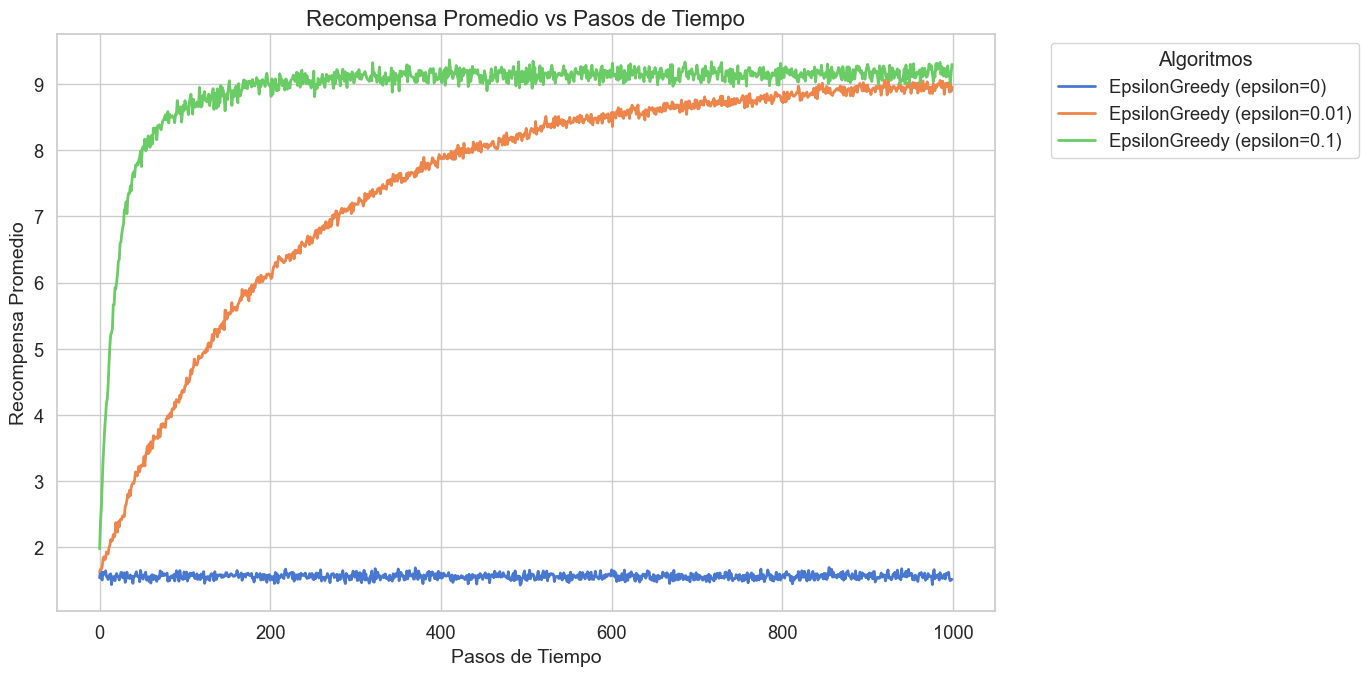

In [25]:
# Graficar los resultados
plot_average_rewards(steps, rewards_normal, algorithms)


### Análisis del Algoritmo e-greedy (Distribución Normal)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 1000 pasos, comparando diferentes niveles de probabilidad de exploración (e).

* **e=0 (Greedy):** Presenta el peor rendimiento, estancándose prematuramente en una recompensa cercana a 1.5. Al no explorar, el algoritmo selecciona el primer brazo con retorno positivo y queda atrapado en un óptimo local, ignorando brazos con medias superiores.

* **e=0.1:** Es el más eficiente en el corto plazo, logrando la mayor pendiente de aprendizaje inicial. Alcanza un estado estacionario (aprox. 9.2 de recompensa) alrededor del paso 200, demostrando que una exploración constante permite identificar rápidamente los mejores brazos.

* **e=0.01:** Muestra un aprendizaje más lento pero constante. Aunque tarda más en identificar el brazo óptimo debido a su baja tasa de exploración, su trayectoria indica que a largo plazo puede igualar o superar a e=0.1, ya que incurre en menos "pérdida por exploración" una vez que el conocimiento del entorno es preciso.

---


In [26]:
if optimal_selections_normal is not None and len(optimal_selections_normal) > 0:
    print(f"optimal selections: {optimal_selections_normal}")

optimal selections: [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.002 0.004 0.004 ... 0.588 0.584 0.59 ]
 [0.012 0.022 0.026 ... 0.894 0.928 0.924]]


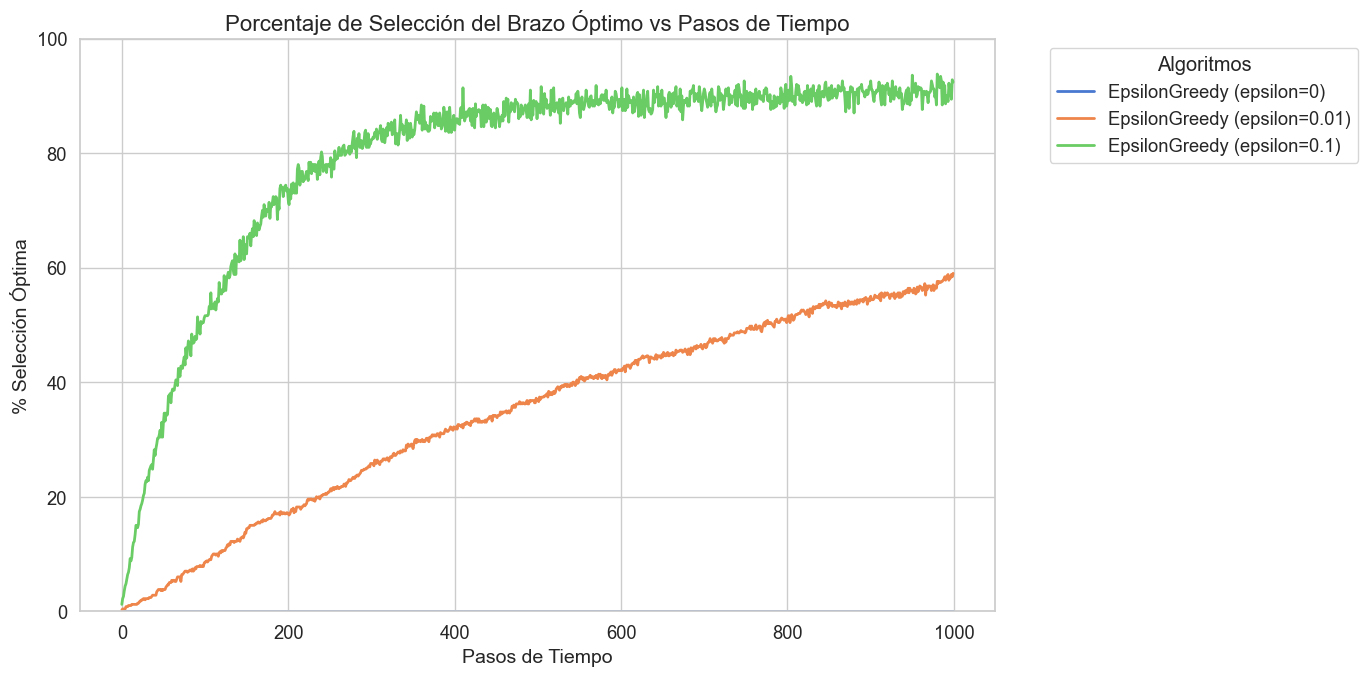

In [27]:
plot_optimal_selections(steps, optimal_selections_normal, algorithms)

Porcentaje de Selección del Brazo Óptimo

- **e = 0.1**: Sobresale al identificar y seleccionar la acción óptima en más del 80% de las ocasiones antes del paso 400, llegando a estabilizarse cerca del 90%.

- **e = 0.01**: Al finalizar los 1000 pasos, apenas alcanza un 60% de selección óptima. Esto confirma que, si bien es más conservador, requiere de un horizonte temporal mucho mayor para converger hacia el brazo ideal.

- **e = 0**: Su porcentaje de selección óptima permanece, no se observa pero se asume entorno a 0. Esto demuestra que la probabilidad de seleccionar el mejor brazo por pura suerte inicial es mínima sin una estrategia de exploración.

---


### Estadisticas de Ganancia VS Pérdida por Algoritmo

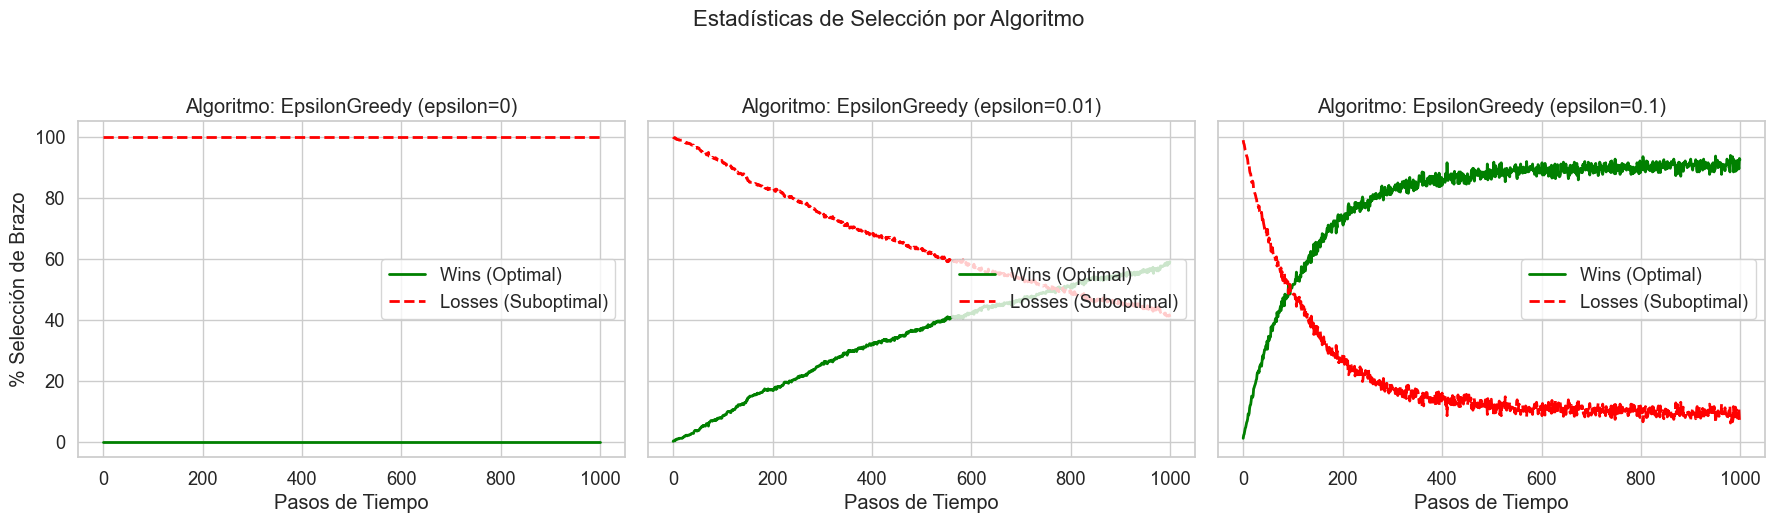

In [28]:
plot_arm_statistics(arm_stats_normal, algorithms)

## Ejecución del experimento sobre distribución Binomial

En este experimento al igual que el anterior usamos 10 brazos, para mantener el mismo experimento que para el caso de distribución normal, pero utilizando una distribución binomial. Se realizan 500 ejecuciones de 1000 pasos cada una. Al igual que en el experimento anterior se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [29]:
# Creación del bandit
bandido = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_binomial, optimal_selections_binomial, arm_stats_binomial = run_experiment(bandido, algorithms, steps, runs, seed)


Bandit with 10 arms: ArmBinomial(n=10, p=0.15), ArmBinomial(n=10, p=0.79), ArmBinomial(n=10, p=0.99), ArmBinomial(n=10, p=0.51), ArmBinomial(n=10, p=0.82), ArmBinomial(n=10, p=0.68), ArmBinomial(n=10, p=0.05), ArmBinomial(n=10, p=0.06), ArmBinomial(n=10, p=0.14), ArmBinomial(n=10, p=0.58)
Optimal arm: 3 with expected reward=9.870317005406523


### Visualización de los resultados del experimento Binomial

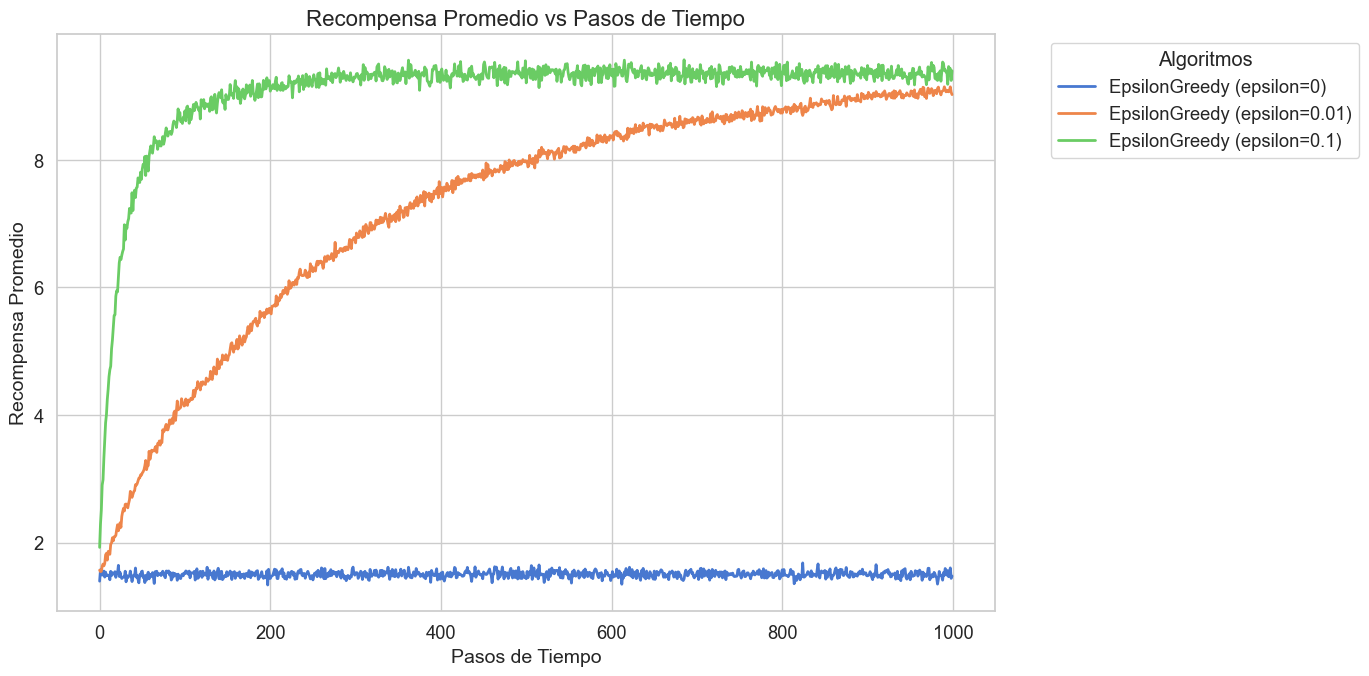

In [30]:
# Graficar los resultados
plot_average_rewards(steps, rewards_binomial, algorithms)

El rendimiento del algoritmo sobre brazos con distribución binomial muestra dinámicas de exploración-explotación similares a la distribución normal, pero con una convergencia a valores de recompensa más altos debido a la naturaleza de la distribución B(n,p).

* **e = 0 (Greedy):** Muestra el rendimiento más bajo, estancándose en una recompensa promedio cercana a **1.5** al igual que la normal. Al carecer de exploración, el algoritmo selecciona un brazo subóptimo basándose en las primeras impresiones y nunca descubre los brazos con mayor probabilidad de éxito (p), quedando atrapado permanentemente en un óptimo local.
* **e = 0.1 (Exploración alta):** Es el más rápido en aprender inicialmente, alcanzando una recompensa de **9.3** en apenas 250 pasos. Sin embargo, su rendimiento se mantiene plano y con mucho "ruido" (fluctuaciones) durante el resto de la simulación. Esto ocurre porque sigue eligiendo brazos aleatorios el 10% de las veces, lo que le impide estabilizarse en el valor máximo teórico.
* **e = 0.01 (Exploración baja):** Es el claro ganador a largo plazo. Aunque su ascenso es más lento, logra superar a e=0.1 alrededor del paso 750, alcanzando una recompensa superior a **9.7** al final de los 2000 pasos. Al explorar solo el 1% de las veces, aprovecha mucho mejor el brazo óptimo una vez identificado, minimizando las pérdidas por decisiones aleatorias.

Mientras que la exploración alta es útil para una identificación rápida, la exploración baja es necesaria para maximizar la recompensa acumulada en experimentos largos, demostrando que **menos exploración suele conducir a un mayor rendimiento final** una vez que el brazo óptimo ha sido descubierto.

---

In [31]:
print(f"optimal selections: {optimal_selections_binomial}")

optimal selections: [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.002 0.002 0.002 ... 0.64  0.642 0.64 ]
 [0.01  0.022 0.026 ... 0.916 0.906 0.914]]


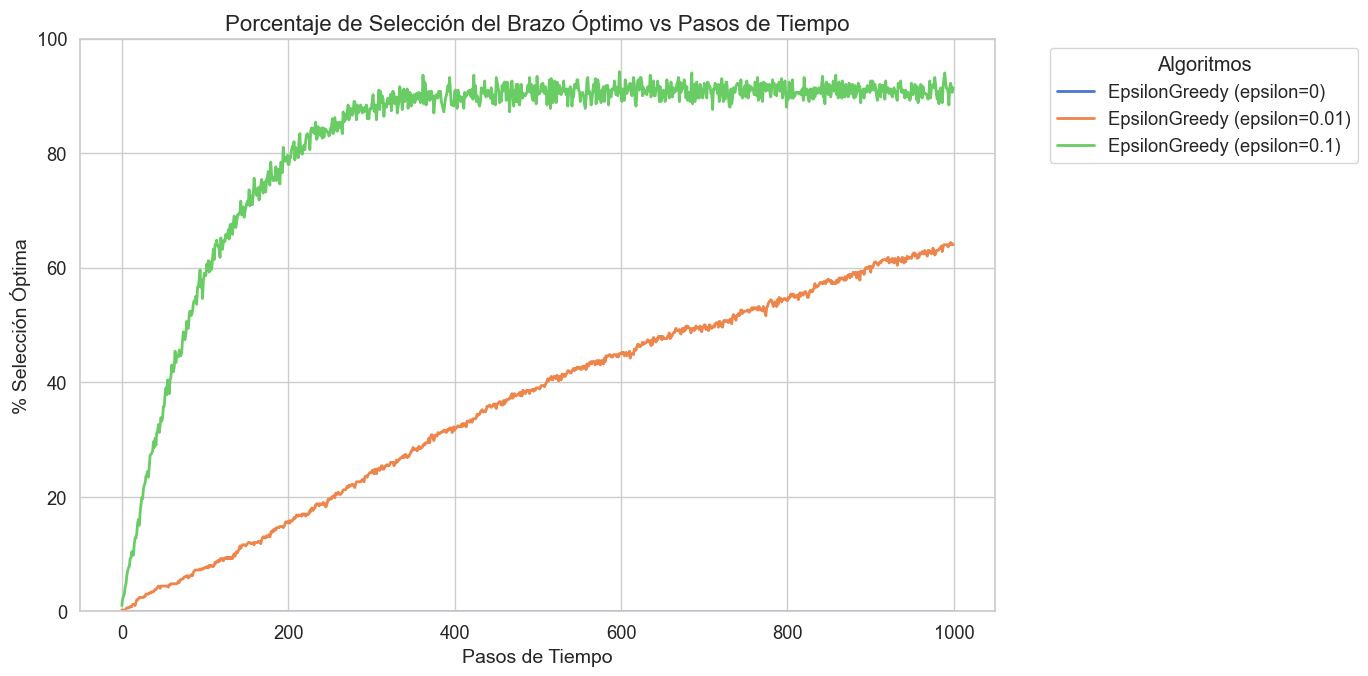

In [32]:
plot_optimal_selections(steps, optimal_selections_binomial, algorithms)

- **e = 0.1**: Identifica con éxito el brazo óptimo de forma acelerada, superando el 80% de selección óptima antes del paso 500 y estabilizándose en un techo cercano al 90%. El 10% restante corresponde a la cuota de exploración forzada por el parámetro.

- **e = 0.01**: Muestra una progresión constante pero mucho más lenta, terminando la simulación con un 70% de selección óptima. A diferencia de la distribución normal, aquí la pendiente de aprendizaje es más suave, sugiriendo que identificar el mejor brazo binomial requiere un mayor número de muestras para diferenciar probabilidades cercanas.

- **ϵ = 0**: Su probabilidad de seleccionar el mejor brazo no mejora con el tiempo, no se visualiza así que se asume cercana a 0%. Esto confirma que, en este entorno, la exploración es indispensable para el éxito del agente.

---


### Estadisticas de Ganancia VS Pérdida por Algoritmo

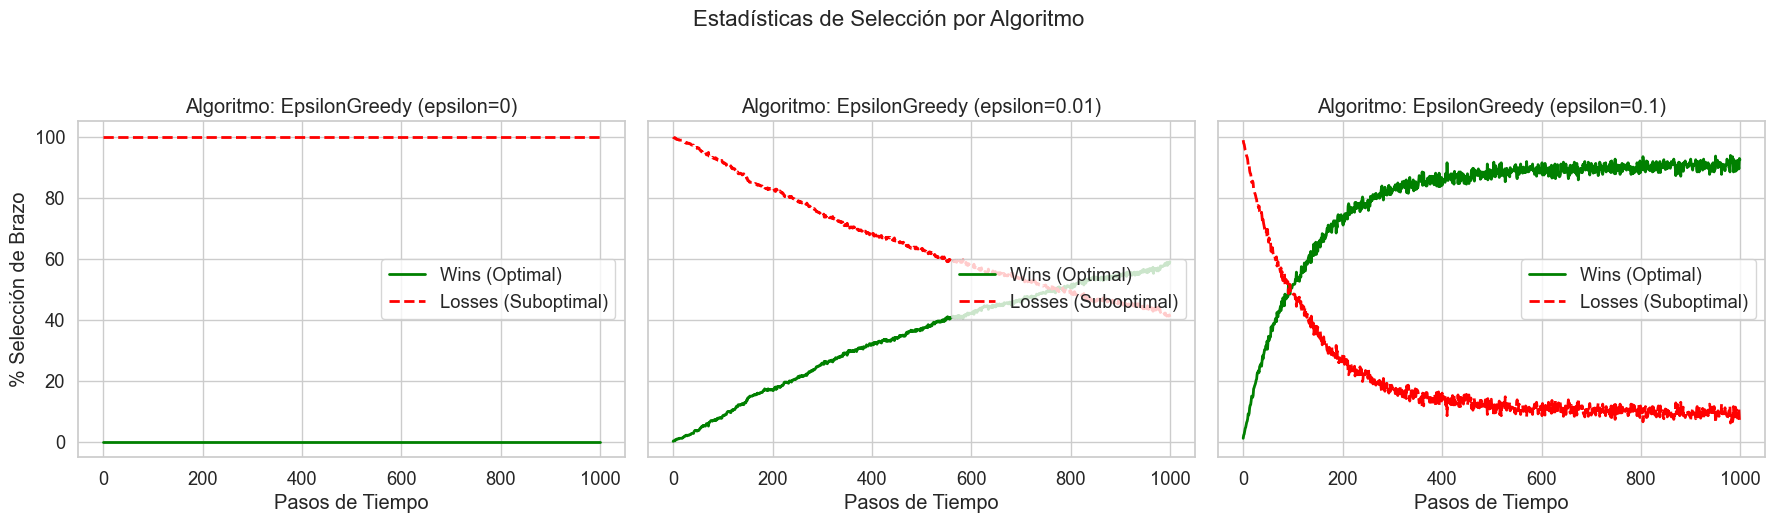

In [33]:
plot_arm_statistics(arm_stats_normal, algorithms)

## Ejecución del experimento Bernoulli

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [34]:
# Creación del bandit
bandido = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_bernoulli, optimal_selections_bernoulli, arm_stats_bernoulli = run_experiment(bandido, algorithms, steps, runs, seed)


Bandit with 10 arms: ArmBernoulli(p=0.70), ArmBernoulli(p=0.60), ArmBernoulli(p=0.55), ArmBernoulli(p=0.17), ArmBernoulli(p=0.18), ArmBernoulli(p=0.96), ArmBernoulli(p=0.25), ArmBernoulli(p=0.32), ArmBernoulli(p=0.78), ArmBernoulli(p=0.24)
Optimal arm: 6 with expected reward=0.9557599814297684


### Visualización de los resultados del experimento Bernoulli

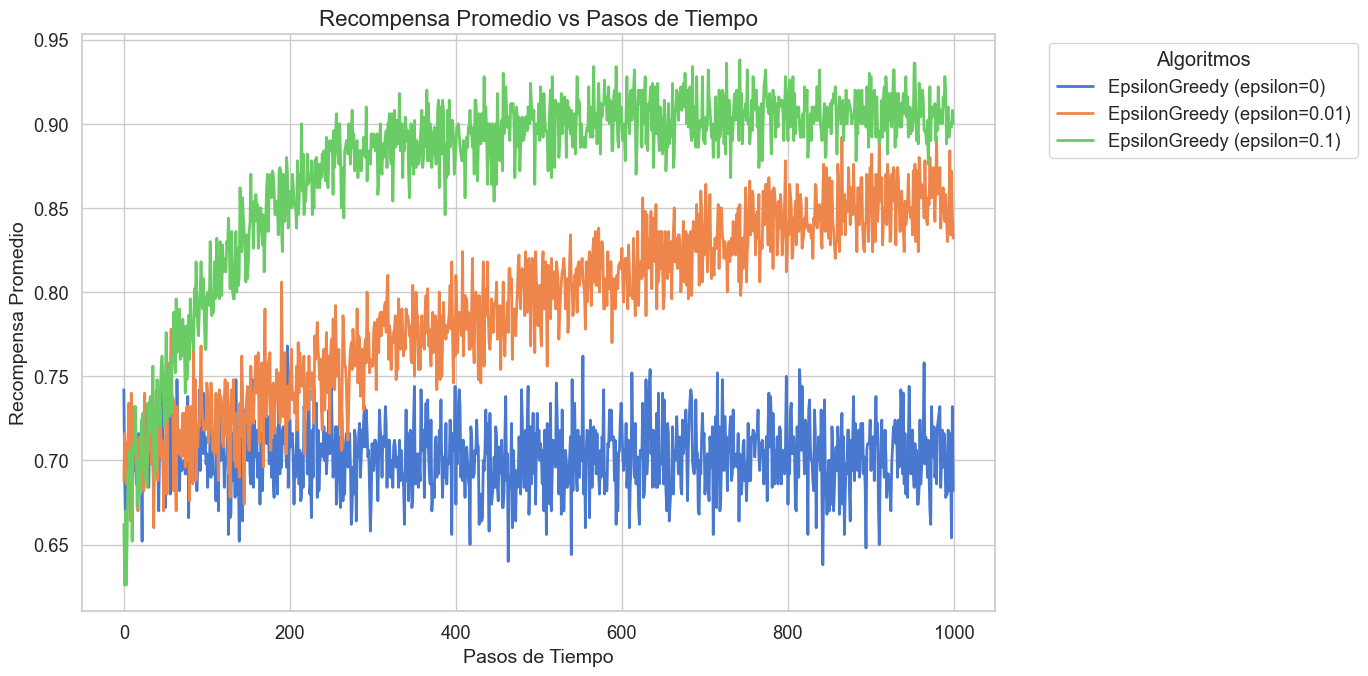

In [35]:
# Graficar los resultados
plot_average_rewards(steps, rewards_bernoulli, algorithms)


- **e = 0 (Greedy)**: Se estanca casi inmediatamente en una recompensa cercana a 0.7. Debido a que las recompensas son binarias, si el primer intento de un brazo es un "fracaso" (0), el algoritmo puede descartar brazos potencialmente óptimos para siempre, quedando atrapado en un rendimiento paupérrimo.

- **e = 0.1**: Logra un aprendizaje muy rápido, alcanzando un promedio de 0.9 antes del paso 500. Sin embargo, muestra una alta volatilidad (picos constantes en la gráfica). Esto se debe a que, en un entorno de 0 y 1, cada decisión de "exploración" aleatoria tiene un impacto drástico en el promedio inmediato.

- **e = 0.01**: Al igual que en los casos anteriores, es la estrategia más sólida a largo plazo. Supera la barrera del 0.85 de recompensa promedio de forma mucho más estable, demostrando que en entornos binarios, una vez identificado el brazo con mejor probabilidad de éxito, reducir la exploración es clave para estabilizar la ganancia.

---

In [36]:
print(f"optimal selections: {optimal_selections_bernoulli}")

optimal selections: [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.002 0.002 ... 0.602 0.598 0.602]
 [0.008 0.016 0.016 ... 0.91  0.894 0.908]]


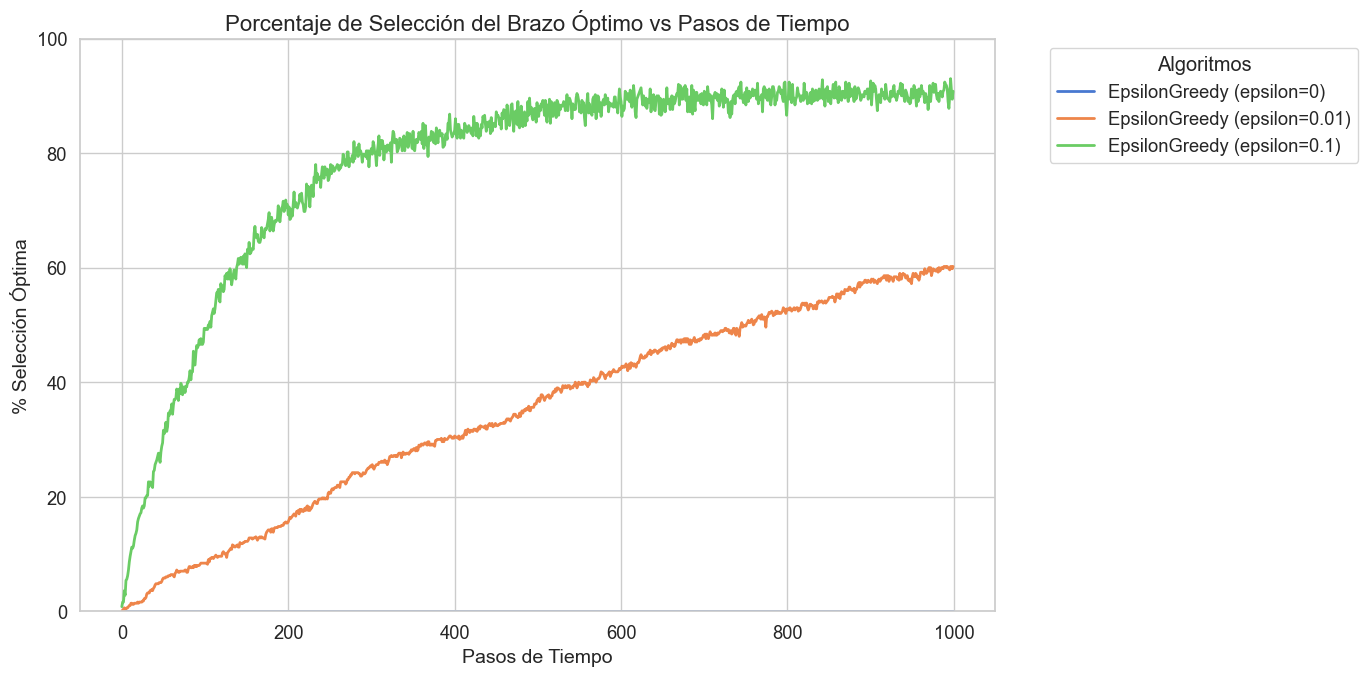

In [37]:
plot_optimal_selections(steps, optimal_selections_bernoulli, algorithms)

- **e = 0.1**: Es extremadamente eficaz para identificar el brazo óptimo en este entorno, estabilizándose por encima del 90% de selección óptima muy rápidamente. Esto indica que, aunque la recompensa promedio sea ruidosa, el algoritmo tiene mucha certeza sobre cuál es el mejor brazo.

- **e = 0.01**: Muestra una pendiente de mejora constante, alcanzando el 70% de selección óptima al final de los 2000 pasos. Su progresión lenta confirma que con muy poca exploración se necesitan miles de iteraciones para diferenciar estadísticamente entre una probabilidad de éxito (p) y otra.

- **e = 0**: Mantiene un porcentaje de selección óptima nulo, reforzando la idea de que en problemas de "éxito/fracaso".

### Estadisticas de Ganancia VS Pérdida por Algoritmo

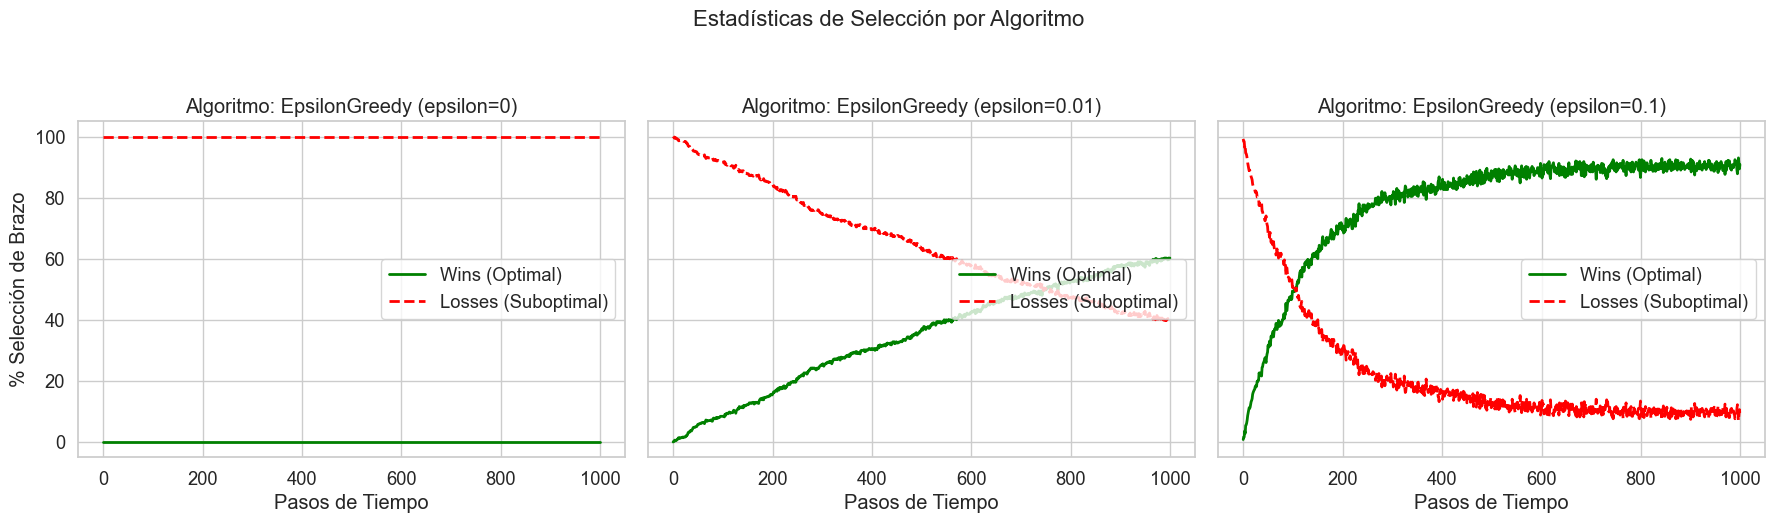

In [38]:
plot_arm_statistics(arm_stats_bernoulli, algorithms)

---

### Conclusiones Generales: Rendimiento y Estrategias

Tras analizar el comportamiento del algoritmo epsilon-Greedy en las tres distribuciones propuestas (Normal, Binomial y Bernoulli), se extraen las siguientes conclusiones sobre el aprendizaje por refuerzo:

#### 1. El Conflicto Exploracion vs. Explotacion

* **e =  0 (Fracaso sistemico):** En todas las distribuciones, la falta de exploracion condena al agente a un rendimiento bajo. Al no probar brazos diferentes, el algoritmo queda bloqueado en la primera opcion que le devuelve una recompensa aceptable, ignorando sistematicamente el brazo optimo.
* **e =  0.1 (Velocidad):** Es la mejor opcion para identificar rapidamente cual es el mejor brazo. Sin embargo, su techo de recompensa es mas bajo porque sigue perdiendo un 10 por ciento de sus acciones en exploraciones aleatorias innecesarias una vez que ya conoce el entorno.
* **e =  0.01 (Eficiencia):** Es el mas eficiente a largo plazo. Aunque requiere mas pasos de tiempo para converger, su perdida acumulada es menor, ya que explota el brazo optimo el 99 por ciento del tiempo.

#### 2. Convergencia y Estabilidad segun la Distribucion

* **Distribucion Normal:** Presenta las curvas mas suaves de aprendizaje debido a la naturaleza continua de las recompensas. El agente diferencia con relativa facilidad las medias de los brazos para identificar el mejor.
* **Distribucion Binomial:** El agente logra obtener recompensas promedio altas, pero la naturaleza discreta de los resultados (conteo de exitos) genera mayor variabilidad inicial en comparacion con la normal.
* **Distribucion de Bernoulli:** Es el entorno mas desafiante. Al recibir unicamente 1 o 0, la señal de recompensa es muy ruidosa. Aqui la exploracion es mas critica que nunca, ya que un solo fracaso inicial en el brazo optimo puede hacer que un algoritmo que explore poco lo descarte para siempre.

#### 3. Tendencias Observadas

* **Dependencia del Horizonte Temporal:** Si el experimento es corto, conviene un epsilon alto (0.1). Si el experimento es largo (mas de 1000 pasos), un epsilon bajo (0.01) acabara obteniendo una recompensa acumulada mucho mayor.
* **Impacto del Ruido:** A medida que pasamos a entornos binarios como Bernoulli, el algoritmo necesita mas tiempo para que sus estimaciones internas de valor converjan a los valores reales de cada brazo.

---

In [39]:
# TODO Modifique los ficheros bandit_experiment.ipynb y https://github.com/ldaniel-hm/eml_k_bandit/blob/main/plotting/plotting.py para incluir en el estudio original las gráficas indicadas.

In [40]:
# TODO Cuando complete el estudio de la familia de algoritmos epsilon-greedy, indique cuál de todas las gráficas que se piden son las más relevantes ¿por qué es esa gráfica o esas gráficas las más importantes?